In [2]:
import sys  
sys.path.insert(0, '../py')
from graviti import *

from numpy.linalg import norm
import numpy as np
import os
import os.path
from os import path
import glob
import h5py
import matplotlib.pyplot as plt
import matplotlib
#matplotlib.use('Agg')
import plotly.express as px
import pandas as pd
import umap
import networkx as nx
from scipy import sparse, linalg
import pickle
from sklearn.preprocessing import normalize, scale
from scipy.sparse import find
import multiprocessing
from joblib import Parallel, delayed
import plotly.graph_objects as go
from plotly.graph_objs import *

import warnings
warnings.filterwarnings('ignore')

from skimage.io import imread, imsave
from skimage.measure import label, regionprops
from skimage.util import invert
import cv2
import csv

import skimage.io
import skimage.measure
import skimage.color
from skimage import exposure, img_as_ubyte
import matplotlib.patches as mpatches

import tifffile
import random

import seaborn as sns; sns.set()

In [23]:
def get_fov(df,row,col):
    fdf = df[(df['fov_row']==row) & (df['fov_col']==col)]
    pos = fdf[fdf.columns[2:4]].to_numpy() # Get the positions of centroids 

    # Building the UMAP graph
    print('Creating the graph')
    nn = fdf.shape[0]//25
    print('The connectivity is '+str(nn))
    A = space2graph(pos,nn)
    
    print('Creating the network')
    G = nx.from_scipy_sparse_matrix(A, edge_attribute='weight')
    
    #get the morphological data and rescale the data by std 
    data = scale(fdf[features].to_numpy(), with_mean=False) 

    print('Generating the descriptor')
    num_cores = multiprocessing.cpu_count() # numb of cores
    row_idx, col_idx, values = find(A) #A.nonzero() # nonzero entries
    processed_list = Parallel(n_jobs=num_cores)(delayed(covd_local)(r,data,row_idx,col_idx) 
                                                                for r in range(A.shape[0])
                                                       )

    # Construct the descriptor array
    descriptor = np.zeros((len(processed_list),processed_list[0][1].shape[0]))
    for r in range(len(processed_list)):
        descriptor[r,:] = processed_list[r][1] # covd descriptors of the connected nodes
    
    print('Generating the field')
    #fdf['field'] = covd_gradient(descriptor,row_idx,col_idx,values)
    fdf['field'] = Parallel(n_jobs=num_cores)(delayed(covd_gradient_parallel)(node,descriptor,row_idx,col_idx,values) 
                                                                for node in range(A.shape[0])
                                                       )
    print('Done')
    return fdf

In [20]:
#dirname = '../h5/id_52/' # the path to *features.npz files 
dirname = '../data/id_52/' # the path to *features.npz files 
sample = '52_FOV' #sys.argv[2]  # the sample id

features = ['area',
            'perimeter',
            'solidity',
            'eccentricity',
            'circularity',
            'mean_intensity',
            'std_intensity',
           ]

In [9]:
counter = 0
for f in glob.glob(dirname+'/*features.npz'): # for every fov
    counter += 1
    if counter == 1:            # set up the data arrays
        data = np.load(f,allow_pickle=True)
        fov = data['fov']
        xy = data['centroids']
        morphology = data['morphology']
    else:                       # update the data arrays
        data = np.load(f,allow_pickle=True)
        fov = np.vstack((fov,data['fov']))
        xy = np.vstack((xy, data['centroids']))
        morphology = np.vstack((morphology, data['morphology']))

# Create dataframes with spatial and morphological measurements
df_fov = pd.DataFrame(data=fov, columns=['fov_row','fov_col']) # field of view dataframe
df_xy = pd.DataFrame(data=xy, columns=['cx','cy'])   # centroid dataframe
df_morphology = pd.DataFrame(data=morphology, columns=['area','perimeter','solidity','eccentricity','circularity','mean_intensity','std_intensity'])

# Concatenate spatial and morphological dataframes
df = pd.concat([df_fov,df_xy, df_morphology],axis=1)

In [18]:
lista = random.choices(list(zip(df.fov_row, df.fov_col)),k=10)
print(lista)

[(31, 32), (6, 19), (6, 45), (14, 42), (44, 39), (23, 10), (6, 42), (37, 11), (6, 10), (18, 37)]


31 32
Creating the graph
The connectivity is 20
Creating the network
Generating the descriptor
Generating the field
Done


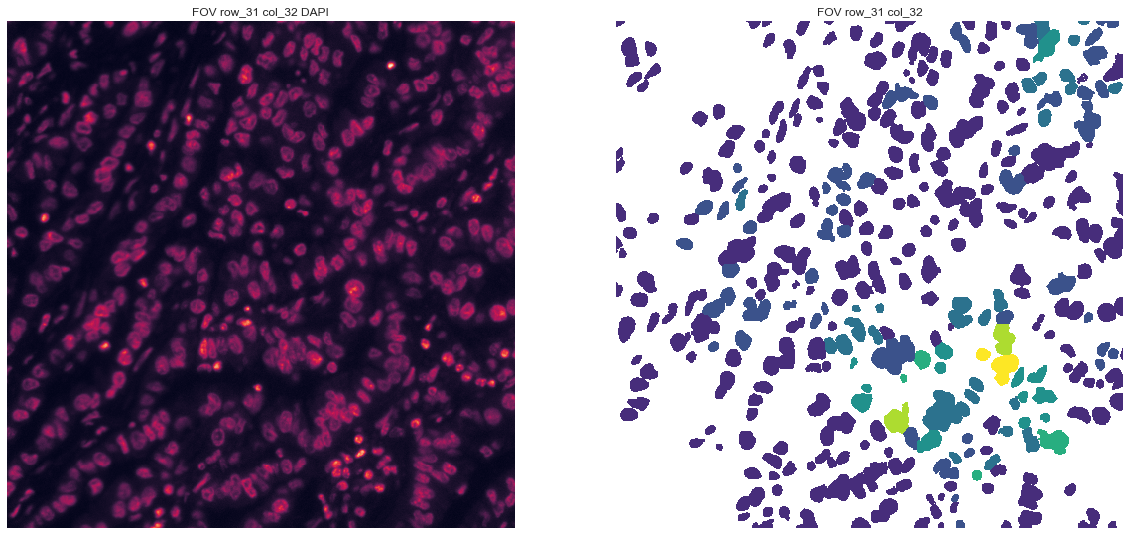

6 19
Creating the graph
The connectivity is 15
Creating the network
Generating the descriptor
Generating the field
Done


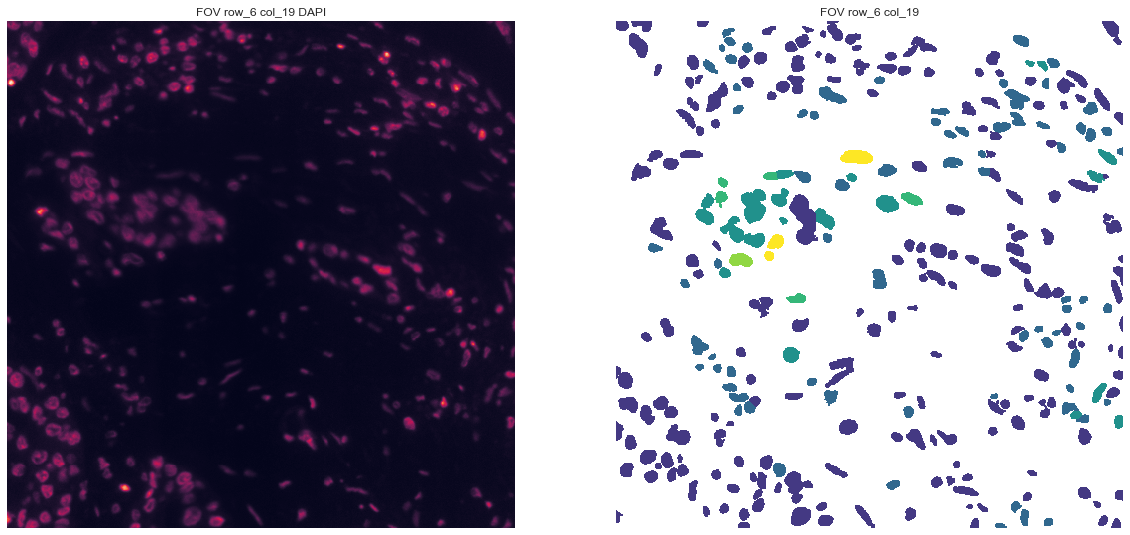

6 45
Creating the graph
The connectivity is 16
Creating the network
Generating the descriptor
Generating the field
Done


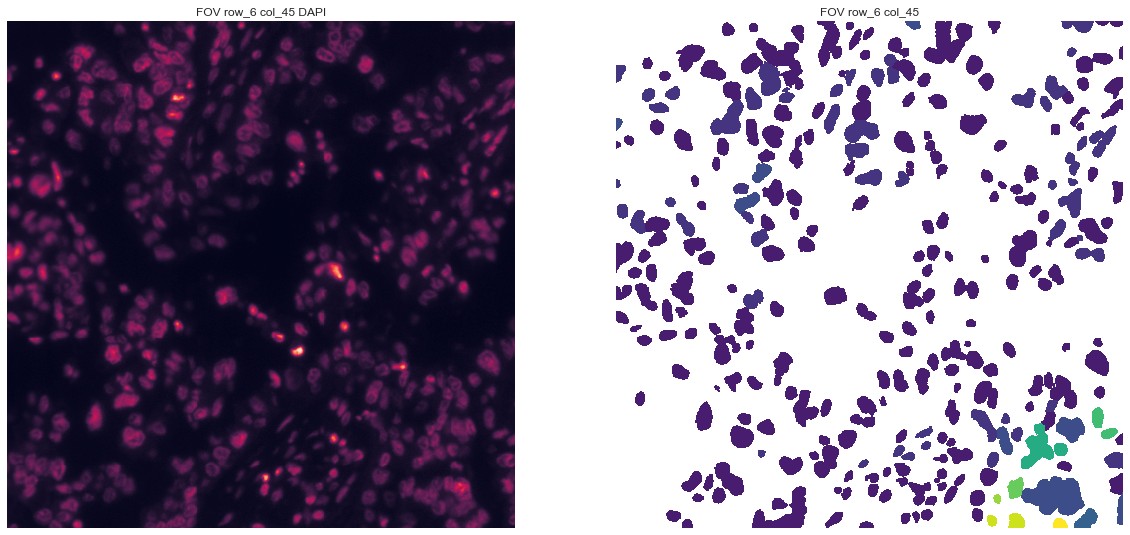

14 42
Creating the graph
The connectivity is 16
Creating the network
Generating the descriptor
Generating the field
Done


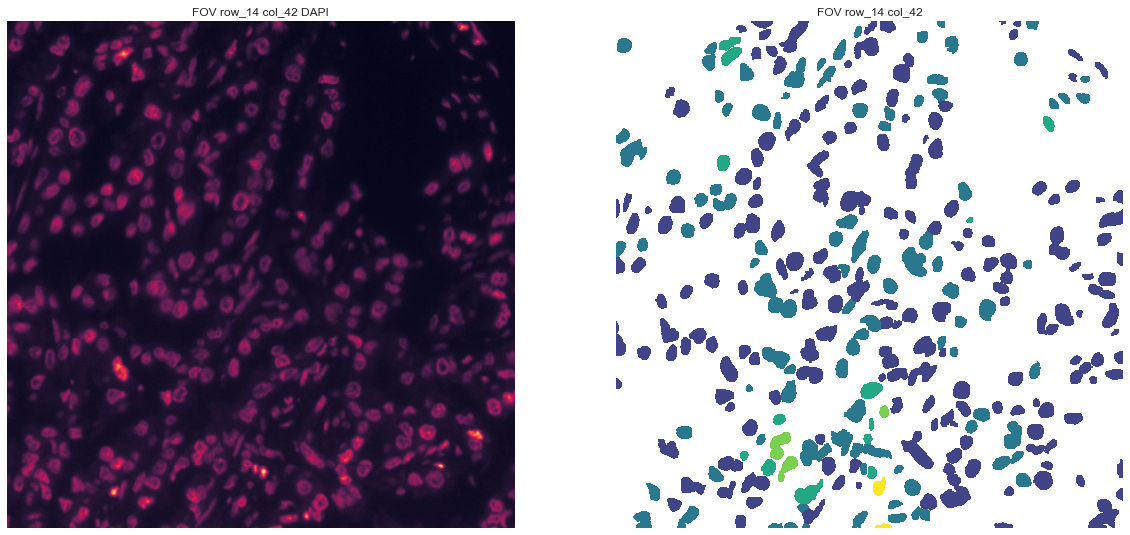

44 39
Creating the graph
The connectivity is 23
Creating the network
Generating the descriptor
Generating the field
Done


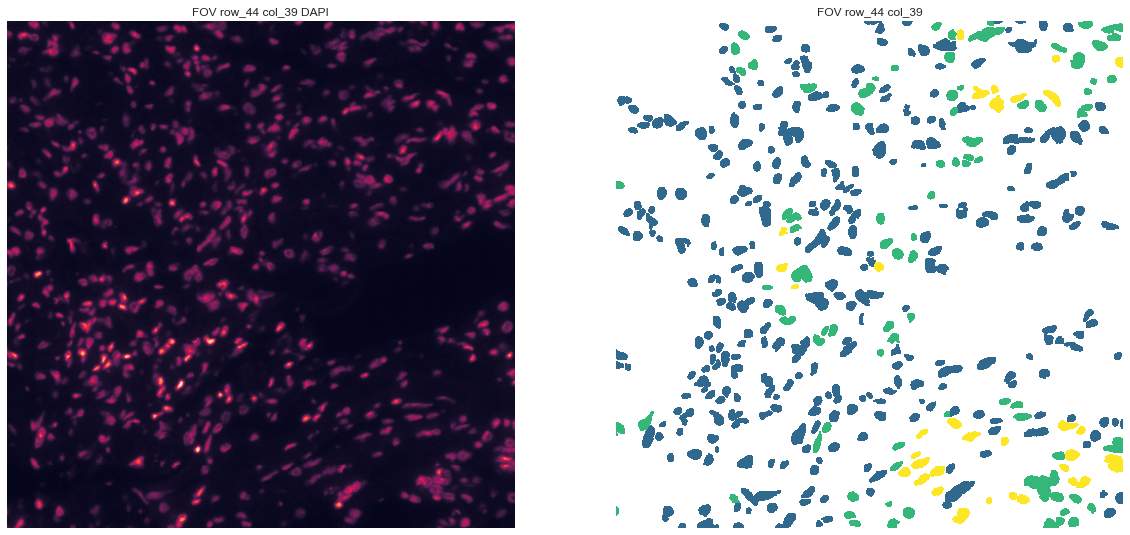

23 10
Creating the graph
The connectivity is 29
Creating the network
Generating the descriptor
Generating the field
Done


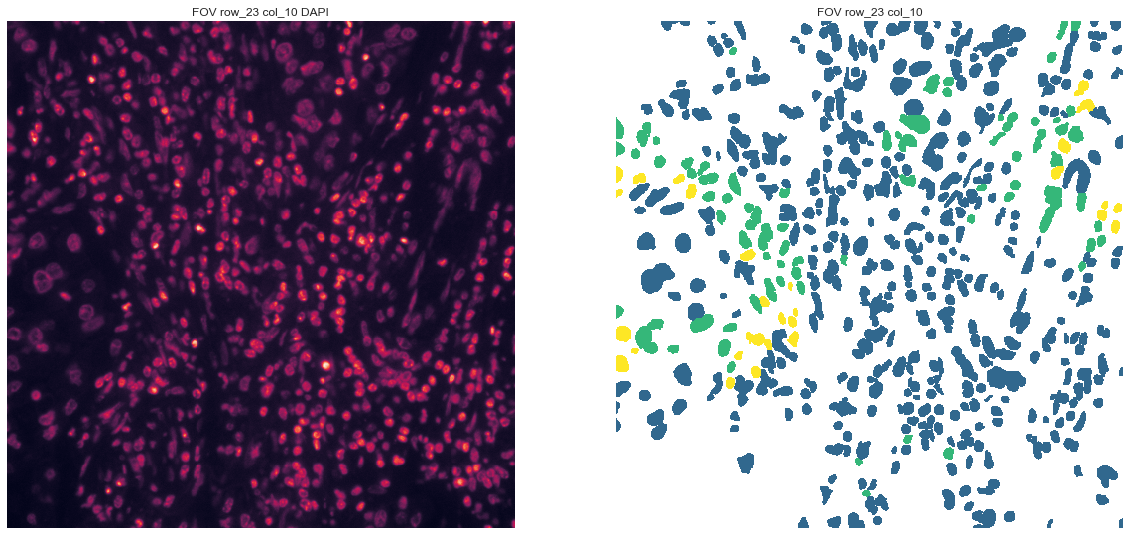

6 42
Creating the graph
The connectivity is 19
Creating the network
Generating the descriptor
Generating the field
Done


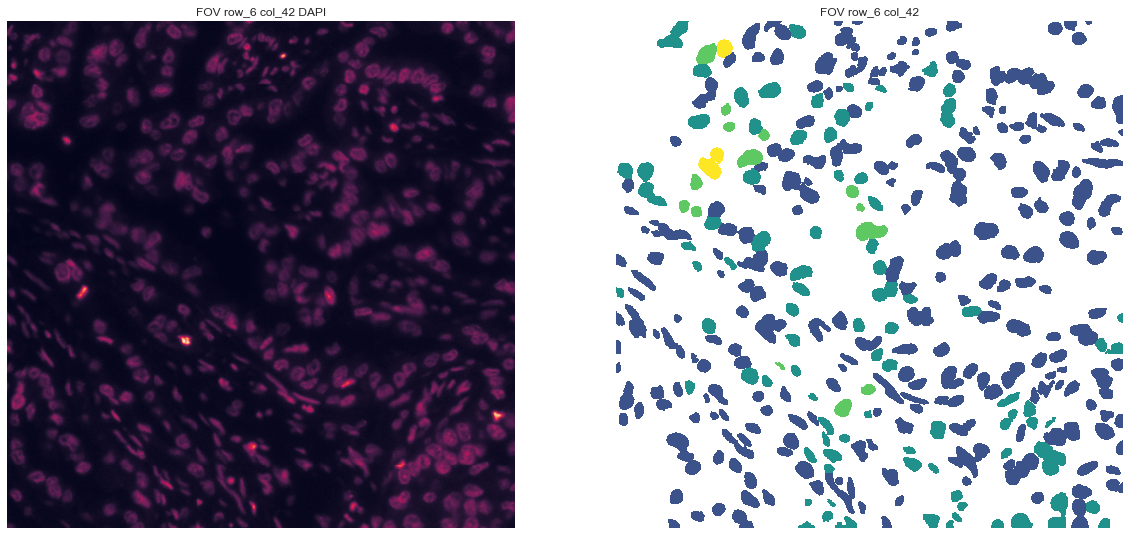

37 11
Creating the graph
The connectivity is 20
Creating the network
Generating the descriptor
Generating the field
Done


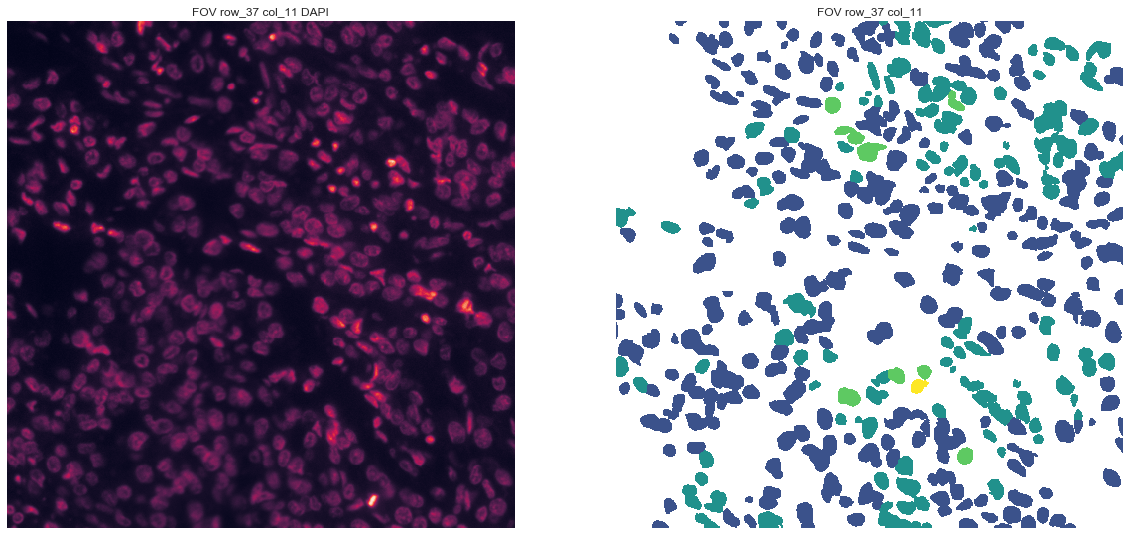

6 10
Creating the graph
The connectivity is 19
Creating the network
Generating the descriptor
Generating the field
Done


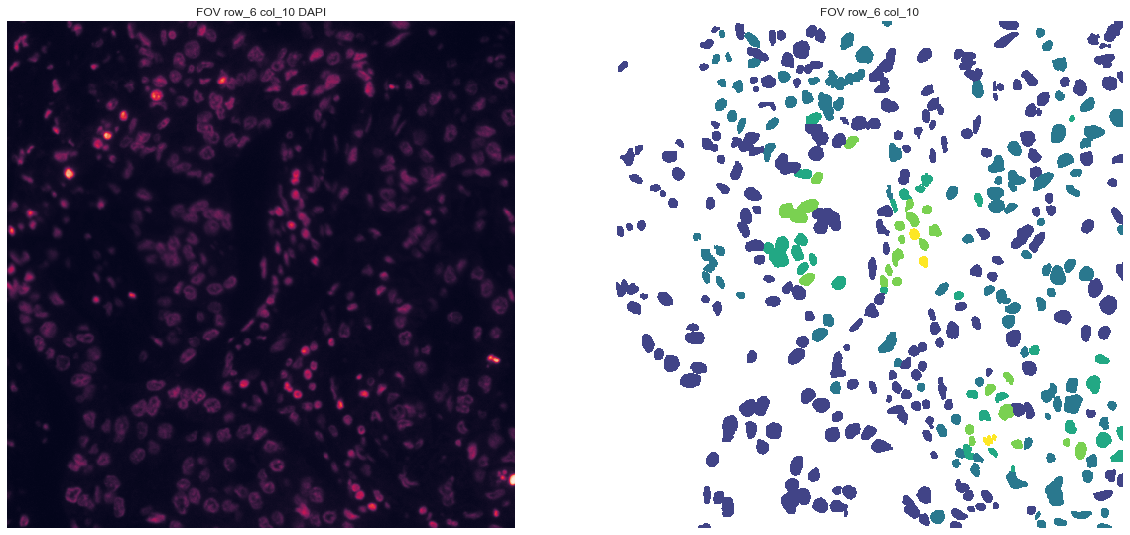

18 37
Creating the graph
The connectivity is 19
Creating the network
Generating the descriptor
Generating the field
Done


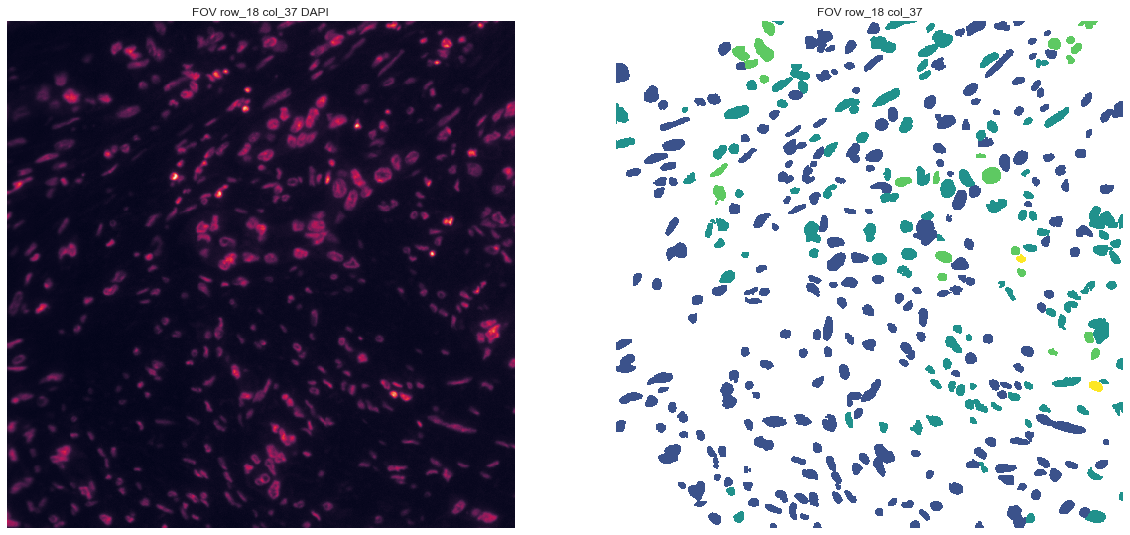

In [21]:
cmap = plt.get_cmap("viridis")
rc_df = df.groupby(['fov_row','fov_col']).size().reset_index().rename(columns={0:'count'}) # the df of row-col fov pairs
for row, col in lista:#random.choices(list(zip(rc_df.fov_row, rc_df.fov_col)),k=5):
    
    print(row,col)
    
    df_fov = get_fov(df,row,col)
    
    # load the h5 file
    h5_file = glob.glob(dirname+r'iMS*._r'+str(row)+'_c'+str(col)+'.h5')[0]   #this file contains the segmented nuclei                                                                                                                    
    fov = h5py.File(h5_file, 'r') # load the current fov segmentation                                                                                                                   
    mask = fov['/exported_watershed_masks'][:]
    mask_reduced = np.squeeze(mask, axis=2) #to get rid of the third dimension                                                                                                          
    mask_label, numb_of_nuclei = label(mask_reduced,return_num=True) # to define the mask_label array
    
    # load dapi file
    basename = os.path.splitext(h5_file)[0]
    dapi_file = basename+'.tif' # the dapi file has to be located in the same directory as the h5 file                                                                                  
    dapi_fov= np.squeeze(imread(dapi_file)) #the dapi tif file of the current FOV                                                                                          
    
    # define new_mask_label associated to clusters
    new_mask_label = np.zeros((512,512)).astype(int) #set to the first integer greater than clusters id
    
    for index, nuclei in df_fov.iterrows(): # for each nucleus in csv in fov
        cx = nuclei['cx'] # read the centroid x coordinate
        cy = nuclei['cy'] # read the centroid y coordinate
        cluster = int(nuclei['field']) # read the cluster label
        for region in regionprops(mask_label,intensity_image=dapi_fov): # for each nucleus in fov
            #if a region is too small or too large do not consider it
            x = 512*int(col)+region.centroid[0] # shift by FOV location                                                                                                                 
            y = 512*int(row)+region.centroid[1] # shift by FOV location                                                                                                                 
            if abs(x - cx) < 1.0E-6 and abs(y - cy) < 1.0E-6: # tolerate some error in the coordinate values
                # find location in mask_label where label is equal to region.label
                new_mask_label[mask_label == region.label] = cluster
    
    fig = plt.figure(figsize=(20, 10))
    # show pre-clustering figure
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(dapi_fov,origin='lower')
    ax1.set_title('FOV row_'+str(row)+' col_'+str(col)+' DAPI')
    ax1.axis('off')
    # Plot clusters
    ax2 = fig.add_subplot(1,2,2)
    ax2 = sns.heatmap(np.rot90(new_mask_label).astype(int),
                      #vmin=0, vmax=df_fov.field.max(), 
                      cmap = cmap,
                      cbar = False, 
                      square = True,
                      mask = np.rot90(new_mask_label).astype(int)==0 # do not show the background
                     )
    ax2.set_title('FOV row_'+str(row)+' col_'+str(col))
    ax2.axis('off')
    # save images as png file
    plt.savefig(basename+'.dapi-clustering.png')
    plt.show()